In [1]:
import numpy
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from data.data_reader import DataReaderZarr, get_data_readers
from batch.data_transforms.db_with_limits import db_with_limits
from batch.label_transforms.refine_label_boundary import refine_label_boundary

plt.rcParams["axes.grid"] = False

years = [2007,2008,2009,2010,2011,2013,2014,2015,2016,2017,2018]
year_codes = [2007205,2008205,2009107,2010205,2011206,2013842,2014807,2015837,2016837,2017843,2018823]
y = 9

survey_path = f'/scratch/disk5/ahmet/data/{years[y]}' #'/Users/apa055/Desktop/data'

surveys = [f'/{year_codes[y]}/ACOUSTIC/GRIDDED/{year_codes[y]}_sv.zarr']
readers = [DataReaderZarr(survey_path + zarr_file) for zarr_file in surveys]

print(years[y])
survey = readers[0]

/home/a39083/.virtualenvs/dino_plain/lib/python3.10/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


2017


# Labeling for a Portion of Data

In [2]:
survey.fish_categories

[1, 27, 5027, 6009]

(array([0., 2., 3.], dtype=float32), array([250786,  57636,  19578]))


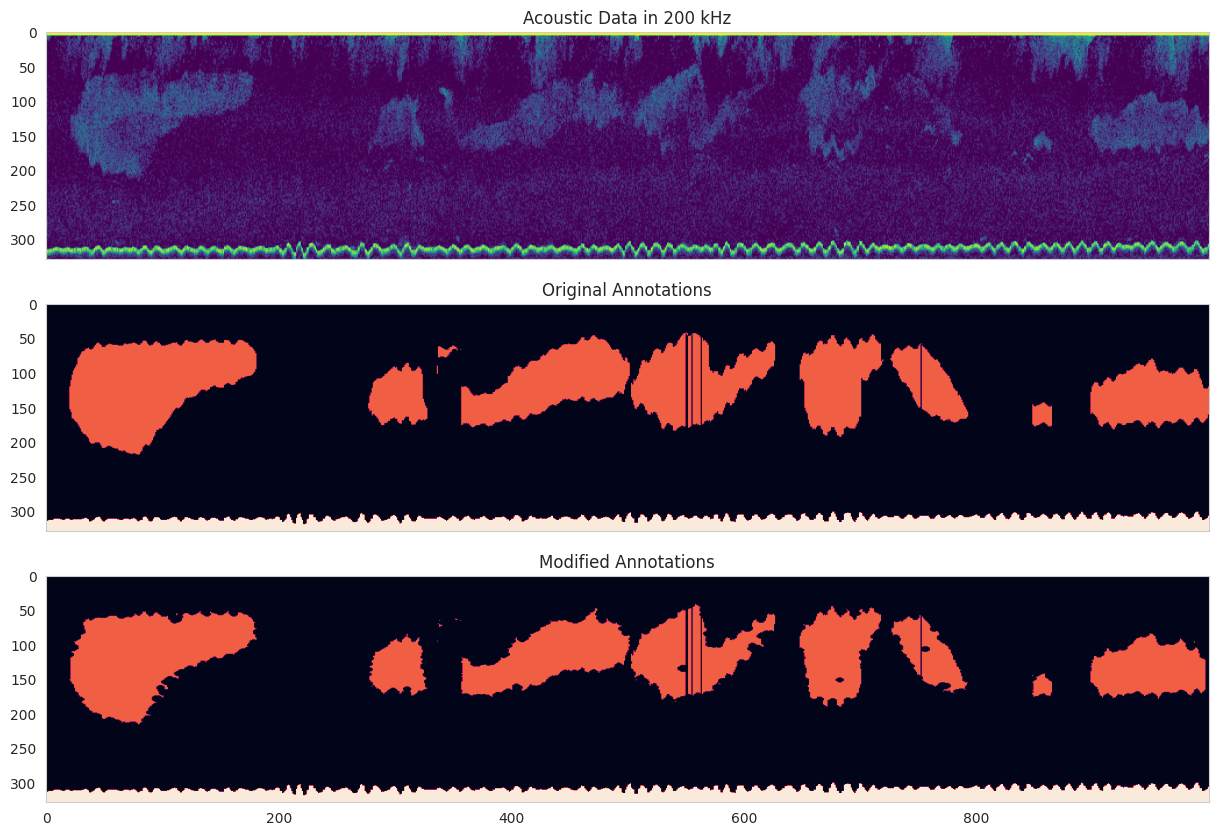

In [9]:
# Example Visualization
frequencies = [18,38,120,200]

ping_start = 1289700 #101000 # 324195 for 2017
ping_end = ping_start+1000 #103800 # 325475 for 2017
ping_slice = slice(ping_start,ping_end)

range_start = 0
range_end = 256+72
range_slice = slice(range_start,range_end)

dat1 = survey.ds.sv.isel(ping_time=ping_slice, range=range_slice).sel(frequency=frequencies)
seabed = survey.get_seabed_mask(idx_ping=ping_start, n_pings=ping_end-ping_start,idx_range=range_start,
                                n_range=range_end-range_start,return_numpy=False)
labels = survey.get_label_slice(idx_ping=ping_start, n_pings=ping_end-ping_start,idx_range=range_start,
                                n_range=range_end-range_start,drop_na=False,return_numpy=False, categories=survey.fish_categories)
labels_values = labels.values


labels_values[labels_values==27.0] = 2.0 # Sandeel values are 2.0

labels_values[labels_values==5027.0] = 4.0 # 5027 values are 4
labels_values[labels_values==6009.0] = 5.0 # 6009 values are 5

# Annotation Modification
modified = refine_label_boundary(ignore_zero_inside_bbox=False).__call__(dat1.values, labels_values, [1],[1])[1]
modified[seabed==1.0] = 3.0

labels_values[seabed==1.0] = 3.0 # Below seabed is 3 (in original annotations)

print(np.unique(labels_values, return_counts=True))
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(15, 10))

axs[0].imshow(db_with_limits(dat1[3].T.values, 1, 2, frequencies)[0], cmap='viridis', aspect="auto")
axs[0].set_title('Acoustic Data in 200 kHz')

im = axs[1].imshow(labels_values.T, aspect="auto")
axs[1].set_title('Original Annotations')

im2 = axs[2].imshow(modified.T, aspect="auto")
axs[2].set_title('Modified Annotations')

plt.show()

# LABEL DATA COORDINATES

In [10]:
# Producing Label Data Coordinates with Labels

patch_size = 8

threshold_percentage = 2

patch_data = []

for i in range(0, modified.shape[0], patch_size):
    for j in range(0, modified.shape[1], patch_size):
        patch = modified[i:i+patch_size, j:j+patch_size]

        count_0 = np.sum(patch == 0)
        count_1 = np.sum(patch == 1)
        count_2 = np.sum(patch == 2)
        count_3 = np.sum(patch == 3)
        
        count_4 = np.sum(patch == 4)
        count_5 = np.sum(patch == 5)

        total_elements = patch.size

        percentage_0 = count_0 / total_elements * 100
        percentage_1 = count_1 / total_elements * 100
        percentage_2 = count_2 / total_elements * 100
        percentage_3 = count_3 / total_elements * 100

        # Assign labels based on conditions
        if percentage_2 > threshold_percentage:
            patch_label = 'sandeel'
        if percentage_1 > threshold_percentage:
            patch_label = 'other'
        if percentage_1 <= threshold_percentage and percentage_2 <= threshold_percentage:
            patch_label = 'background'
        if percentage_1 > threshold_percentage and percentage_2 > threshold_percentage:
            patch_label = 'sandeel_other'
        if count_3 >= total_elements-8:
            patch_label = 'ignore'

        if count_4 > 4 or count_5 > 4:
            patch_label = 'ignored_fish'

        if 'sandeel' in patch_label and count_3 > 2:
            patch_label = 'sandeel_seabed'
        elif 'other' in patch_label and count_3 > 2:
            patch_label = 'other_seabed'
        elif 'background' in patch_label and 0 < count_3 < total_elements-8:
            patch_label = 'seabed'            
        elif 'sandeel_other' in patch_label and count_3 > 0:
            patch_label = 'sandeel_other_seabed'

        center_x = i + patch_size // 2
        center_y = j + patch_size // 2
        patch_data.append((center_x, center_y, patch_label))

dtype = [('center_x', int), ('center_y', int), ('label', 'U20')]

patch_data_array = np.array(patch_data, dtype=dtype)


In [11]:
patch_data_array

array([(  4,   4, 'background'), (  4,  12, 'background'),
       (  4,  20, 'background'), ..., (996, 308, 'seabed'),
       (996, 316, 'ignore'), (996, 324, 'ignore')],
      dtype=[('center_x', '<i8'), ('center_y', '<i8'), ('label', '<U20')])

In [5]:
np.unique(patch_data_array['label'],return_counts=True)

(array(['background', 'ignore', 'ignored_fish', 'seabed'], dtype='<U20'),
 array([13310,   256,     2,   432]))

# Visualization of Single Class

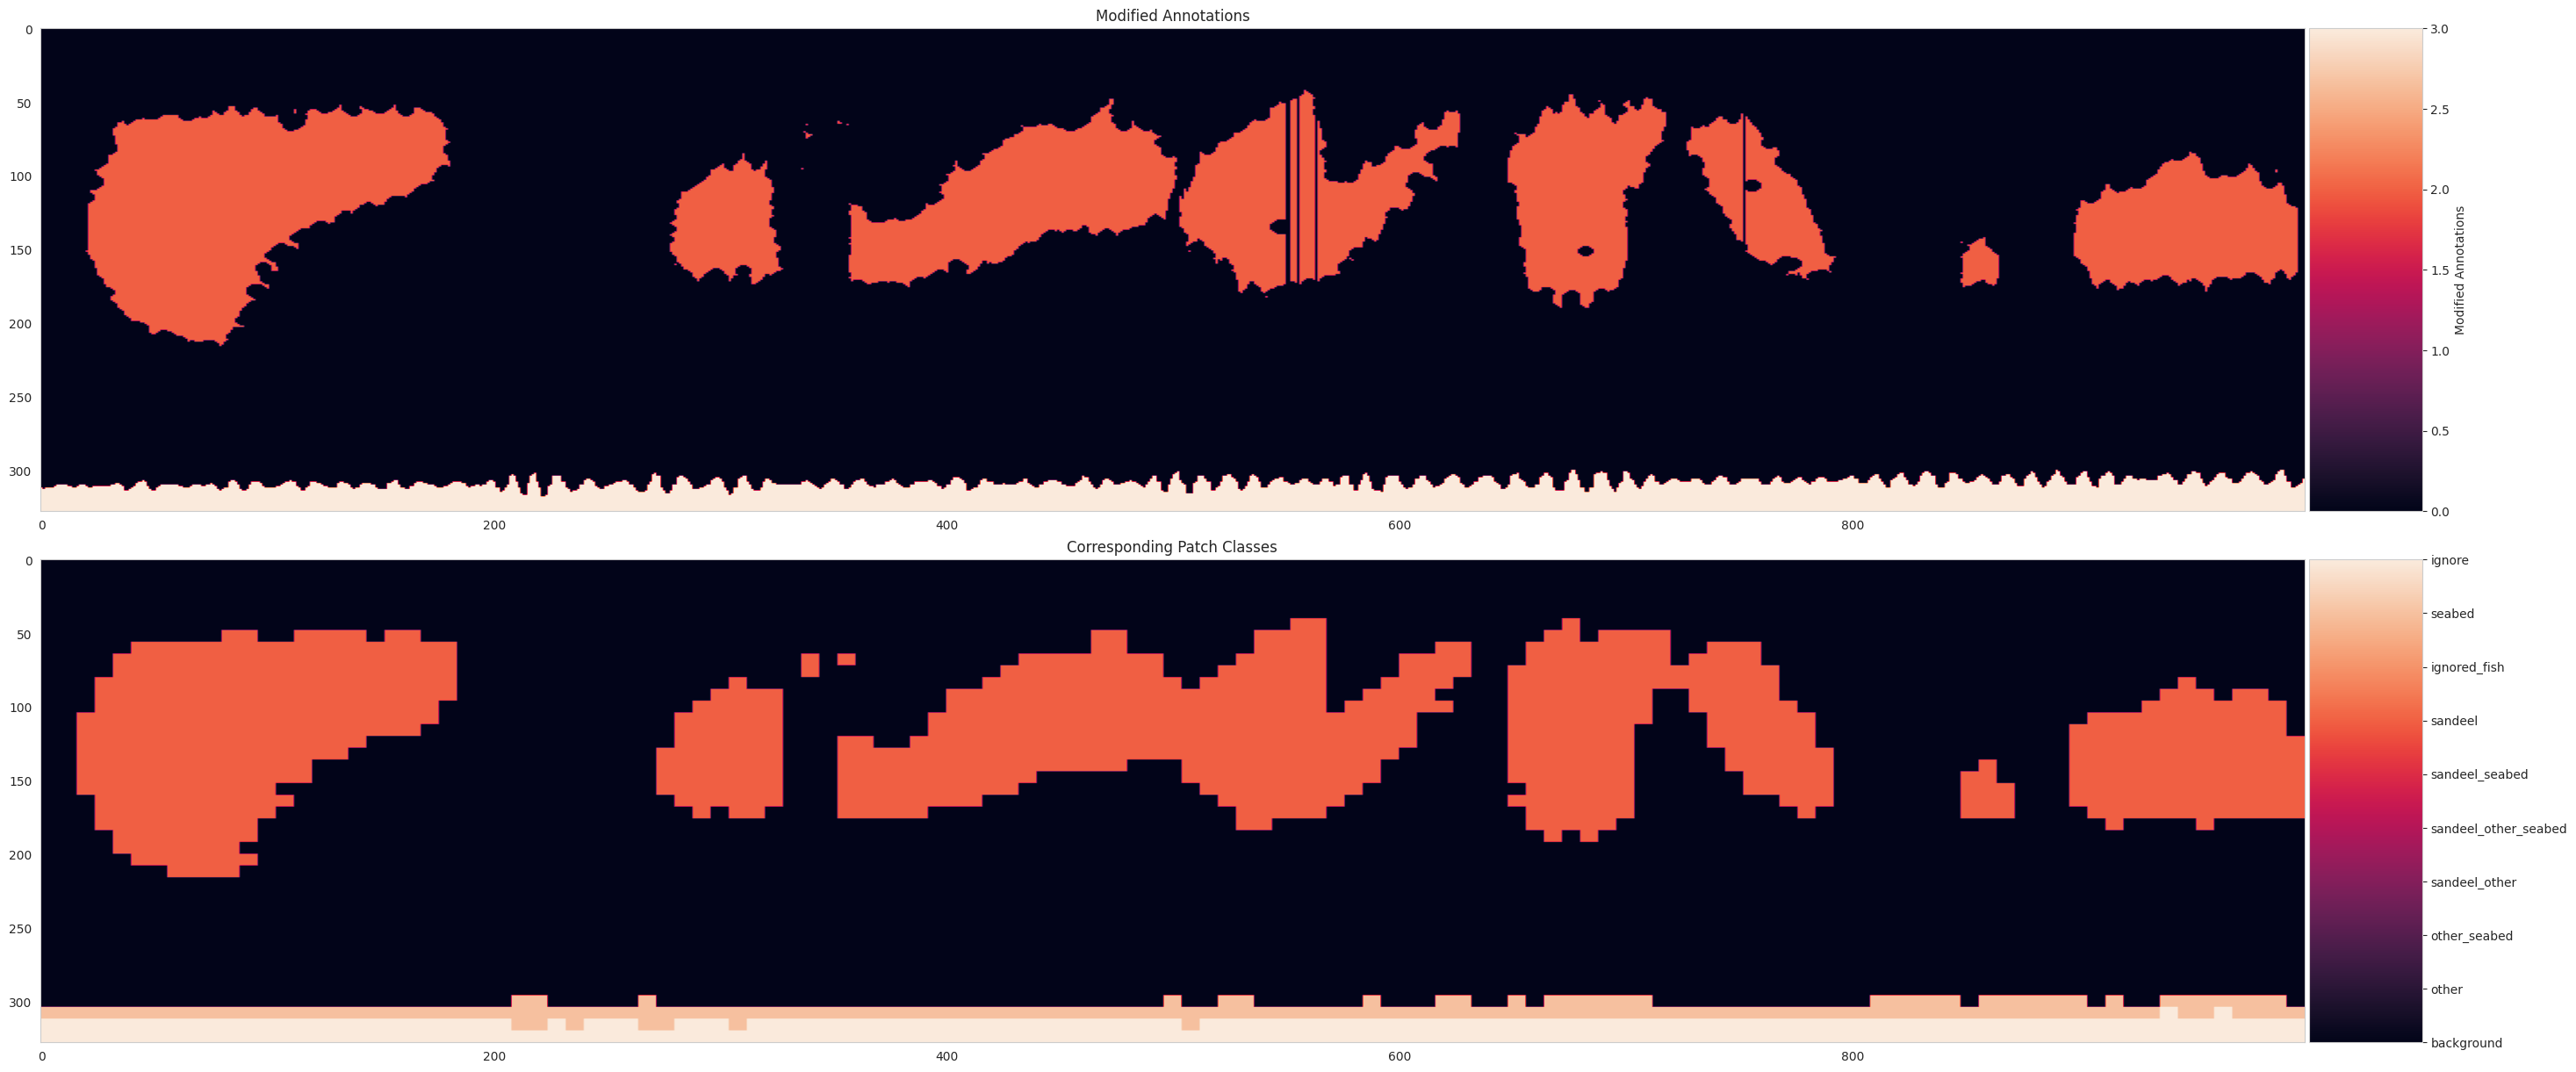

In [12]:
# Visualization

labels_from_patch_data = np.empty_like(modified, dtype=object)

for center_x, center_y, label in patch_data_array:
    start_x = max(0, center_x - patch_size // 2)
    end_x = min(modified.shape[0], center_x + patch_size // 2)
    start_y = max(0, center_y - patch_size // 2)
    end_y = min(modified.shape[1], center_y + patch_size // 2)
    
    labels_from_patch_data[start_x:end_x, start_y:end_y] = label

# Transpose the data for visualization
transposed_modified = modified.T
transposed_labels = labels_from_patch_data.T

# Map string labels to numerical values
label_mapping = {'background': 0, 'other': 1, 'other_seabed': 2, 'sandeel_other': 3,
                 'sandeel_other_seabed': 4, 'sandeel_seabed': 5, 'sandeel': 6, 'ignored_fish': 7, 'seabed': 8, 'ignore': 9}
numeric_labels = np.vectorize(label_mapping.get)(transposed_labels)

# Set up the figure with subplots
fig, ax = plt.subplots(2, 1, figsize=(35, 15))

# Plot the original 'modified' data
im1 = ax[0].imshow(transposed_modified, aspect="auto")
ax[0].set_title('Modified Annotations')
divider1 = make_axes_locatable(ax[0])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(im1, cax=cax1, label='Modified Annotations')

# Plot the corresponding 'labels' data on top of 'modified' data
im2 = ax[1].imshow(numeric_labels, vmin=0, vmax=len(label_mapping) - 1, aspect="auto")
ax[1].set_title('Corresponding Patch Classes')
divider2 = make_axes_locatable(ax[1])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar2 = plt.colorbar(im2, cax=cax2, ticks=range(len(label_mapping)))
cbar2.set_ticklabels(list(label_mapping.keys()))

# Adjust space between subplots
plt.subplots_adjust(hspace=0.1)

plt.show()


# Calculation for the whole Survey

In [2]:
survey.fish_categories

[1, 27, 5027, 6009]

In [4]:
import numpy as np
from tqdm import tqdm

frequencies = [18, 38, 120, 200]
patch_size = 8
threshold_percentage = 2

patch_data = []

batch_size = 12800

son_hesap = patch_size*((survey.shape[0]-patch_size)//patch_size)

# Iterate over the array in batches
for ping_start in tqdm(range(0, son_hesap, batch_size), desc="Processing batches"):
    ping_end = min(ping_start + batch_size, son_hesap)
    ping_slice = slice(ping_start, ping_end)

    range_start = 0
    range_end = 704
    range_slice = slice(range_start, range_end)

    dat1 = survey.ds.sv.isel(ping_time=ping_slice, range=range_slice).sel(frequency=frequencies)
    dat1_200 = db_with_limits(dat1[3].values, 1, 2, frequencies)[0]
    dat1_all = db_with_limits(dat1.values, 1, 2, frequencies)[0]
    
    seabed = survey.get_seabed_mask(idx_ping=ping_start, n_pings=ping_end-ping_start, idx_range=range_start,
                                    n_range=range_end-range_start, return_numpy=False)
    labels = survey.get_label_slice(idx_ping=ping_start, n_pings=ping_end-ping_start, idx_range=range_start,
                                    n_range=range_end-range_start, drop_na=False, return_numpy=False, categories=survey.fish_categories)
    labels_values = labels.values

    # Update 27 as 2 for easy colorbar
    labels_values[labels_values == 27.0] = 2.0
    labels_values[labels_values==5027.0] = 4.0
    labels_values[labels_values==6009.0] = 5.0

    # Annotation Modification
    modified = refine_label_boundary(ignore_zero_inside_bbox=False).__call__(dat1.values, labels_values, [1], [1])[1]
    modified[seabed == 1.0] = 3.0


    for i in range(0, modified.shape[0], patch_size):
        for j in range(0, modified.shape[1], patch_size):
            #Sv_200_mean = dat1_200[i:i+patch_size, j:j+patch_size].mean()
            Sv_all_mean = dat1_all[:,i:i+patch_size, j:j+patch_size].mean()
            patch = modified[i:i+patch_size, j:j+patch_size]

            count_0 = np.sum(patch == 0)
            count_1 = np.sum(patch == 1)
            count_2 = np.sum(patch == 2)
            count_3 = np.sum(patch == 3)
            
            count_4 = np.sum(patch == 4)
            count_5 = np.sum(patch == 5)

            total_elements = patch.size

            percentage_0 = count_0 / total_elements * 100
            percentage_1 = count_1 / total_elements * 100
            percentage_2 = count_2 / total_elements * 100
            percentage_3 = count_3 / total_elements * 100

            if percentage_2 > threshold_percentage:
                patch_label = 'sandeel'
            if percentage_1 > threshold_percentage:
                patch_label = 'other'
            if percentage_1 <= threshold_percentage and percentage_2 <= threshold_percentage:
                patch_label = 'background'
            if percentage_1 > threshold_percentage and percentage_2 > threshold_percentage:
                patch_label = 'sandeel_other'
            if count_3 >= total_elements-8:
                patch_label = 'ignore'
                
            if count_4 > 4 or count_5 > 4:
                patch_label = 'ignored_fish'

            if 'sandeel' in patch_label and count_3 > 2:
                patch_label = 'sandeel_seabed'
            elif 'other' in patch_label and count_3 > 2:
                patch_label = 'other_seabed'
            elif 'background' in patch_label and 0 < count_3 < total_elements-8:
                patch_label = 'seabed'            
            elif 'sandeel_other' in patch_label and count_3 > 0:
                patch_label = 'sandeel_other_seabed'

            center_x = i + patch_size // 2 + ping_start
            center_y = j + patch_size // 2
            patch_data.append((center_x, center_y, patch_label, count_1, count_2, count_3, Sv_all_mean, total_elements))

dtype = [('center_x', int), ('center_y', int), ('label', 'U20'), ('count_1', int), ('count_2', int), ('count_3', int), ('Sv_all_mean', float), ('total_elements', int)]

patch_data_array_all = np.array(patch_data, dtype=dtype)

np.save(f'/scratch/disk5/ahmet/data/{years[y]}/{year_codes[y]}/ACOUSTIC/GRIDDED/{year_codes[y]}_patch_data_array_all_{patch_size}w.npy', patch_data_array_all)


Processing batches:   1%|          | 1/118 [00:20<39:50, 20.43s/it]


KeyboardInterrupt: 

In [108]:

indices_to_remove = np.where(patch_data_array_all['label'] == 'ignore')[0]

filtered_array = np.delete(patch_data_array_all, indices_to_remove, axis=0)

In [119]:
patch_data_array_all[:2]

array([(4,  4, 'background', 0, 0, 0, -15.73769449, 64),
       (4, 12, 'background', 0, 0, 0, -49.98030333, 64)],
      dtype=[('center_x', '<i8'), ('center_y', '<i8'), ('label', '<U20'), ('count_1', '<i8'), ('count_2', '<i8'), ('count_3', '<i8'), ('Sv_all_mean', '<f8'), ('total_elements', '<i8')])

In [132]:
np.unique(patch_data_array_all['label'], return_counts=True)

(array(['background', 'ignore', 'ignored_fish', 'other', 'other_seabed',
        'sandeel', 'sandeel_other', 'sandeel_other_seabed',
        'sandeel_seabed', 'seabed'], dtype='<U20'),
 array([7090594, 9607345,    1368,   12616,    1083,   51771,      62,
              1,     955,  208688]))

# Undersampling the patch data array

In [133]:

years = [2007,2008,2009,2010,2011,2013,2014,2015,2016,2017,2018]
year_codes = [2007205,2008205,2009107,2010205,2011206,2013842,2014807,2015837,2016837,2017843,2018823]
y = 10

survey_path = f'/scratch/disk5/ahmet/data/{years[y]}' #'/Users/apa055/Desktop/data'

surveys = [f'/{year_codes[y]}/ACOUSTIC/GRIDDED/{year_codes[y]}_sv.zarr']
readers = [DataReaderZarr(survey_path + zarr_file) for zarr_file in surveys]

print(years[y])
survey = readers[0]

patch_size = 8

loaded_patch_data_array = np.load(f'/scratch/disk5/ahmet/data/{years[y]}/{year_codes[y]}/ACOUSTIC/GRIDDED/{year_codes[y]}_patch_data_array_all_{patch_size}w.npy')
np.array(np.unique(loaded_patch_data_array['label'], return_counts=True))

2018


array([['background', 'ignore', 'ignored_fish', 'other', 'other_seabed',
        'sandeel', 'sandeel_other', 'sandeel_other_seabed',
        'sandeel_seabed', 'seabed'],
       ['7090594', '9607345', '1368', '12616', '1083', '51771', '62',
        '1', '955', '208688']], dtype='<U21')

In [120]:
loaded_patch_data_array[:2]

array([(4,  4, 'background', 0, 0, 0, -17.84742832, 64),
       (4, 12, 'background', 0, 0, 0, -53.31348663, 64)],
      dtype=[('center_x', '<i8'), ('center_y', '<i8'), ('label', '<U20'), ('count_1', '<i8'), ('count_2', '<i8'), ('count_3', '<i8'), ('Sv_200_mean', '<f8'), ('total_elements', '<i8')])

In [134]:
import pandas as pd
np.random.seed(1)
# Undersampling the patch_data_array_all

df = pd.DataFrame(loaded_patch_data_array)

df_filtered = df[df['label'] != 'ignore']
df_filtered = df_filtered[df_filtered['label'] != 'ignored_fish']

# Group by 'label' and sample 6000 instances for each group
undersampled_df = df_filtered.groupby('label', group_keys=False).apply(lambda x: x.sample(min(51771, len(x)), replace=False))

undersampled_patch_data_array_all = undersampled_df.to_records(index=False)

np.save(f'/scratch/disk5/ahmet/data/{years[y]}/{year_codes[y]}/ACOUSTIC/GRIDDED/{year_codes[y]}_undersampled_patch_data_array_all_{patch_size}w.npy', np.array(undersampled_patch_data_array_all))


In [135]:
# Loadeing the saved numpy array
undersampled_patch_data_array_all = np.load(f'/scratch/disk5/ahmet/data/{years[y]}/{year_codes[y]}/ACOUSTIC/GRIDDED/{year_codes[y]}_undersampled_patch_data_array_all_{patch_size}w.npy', allow_pickle=True)
np.array(np.unique(undersampled_patch_data_array_all['label'],return_counts=True))

array([['background', 'other', 'other_seabed', 'sandeel',
        'sandeel_other', 'sandeel_other_seabed', 'sandeel_seabed',
        'seabed'],
       [51771, 12616, 1083, 51771, 62, 1, 955, 51771]], dtype=object)

In [116]:
loaded_patch_data_array

array([(      4,   4, 'background', 0, 0,  0, -17.84742832, 64),
       (      4,  12, 'background', 0, 0,  0, -53.31348663, 64),
       (      4,  20, 'background', 0, 0,  0, -58.7920364 , 64), ...,
       (1500732, 684, 'ignore', 0, 0, 64, -66.83211501, 64),
       (1500732, 692, 'ignore', 0, 0, 64, -67.0610924 , 64),
       (1500732, 700, 'ignore', 0, 0, 64, -69.80219031, 64)],
      dtype=[('center_x', '<i8'), ('center_y', '<i8'), ('label', '<U20'), ('count_1', '<i8'), ('count_2', '<i8'), ('count_3', '<i8'), ('Sv_200_mean', '<f8'), ('total_elements', '<i8')])

In [91]:
y = 1
# Loadeing the saved numpy array
undersampled_patch_data_array_all = np.load(f'/scratch/disk5/ahmet/data/{years[y]}/{year_codes[y]}/ACOUSTIC/GRIDDED/{year_codes[y]}_undersampled_patch_data_array_all_{patch_size}w.npy', allow_pickle=True)
print(len(undersampled_patch_data_array_all))
np.array(np.unique(undersampled_patch_data_array_all['label'],return_counts=True))

117360


array([['background', 'other', 'other_seabed', 'sandeel',
        'sandeel_other', 'sandeel_other_seabed', 'sandeel_seabed',
        'seabed'],
       [31770, 31770, 3816, 16055, 54, 4, 2121, 31770]], dtype=object)

In [103]:
np.load('/scratch/disk5/ahmet/data/2017/2017843/ACOUSTIC/GRIDDED/2017843_undersampled_patch_data_array_all_8w.npy', allow_pickle=True)

array([( 769404, 172, 'background', 0, 0,  0, -74.26452142, 64),
       ( 418612,  68, 'background', 0, 0,  0, -75.        , 64),
       ( 640772, 188, 'background', 0, 0,  0, -73.88565958, 64), ...,
       (1000692, 284, 'seabed', 0, 0, 35, -68.17342982, 64),
       (1421676, 460, 'seabed', 0, 0, 42, -45.76758297, 64),
       (1177820, 364, 'seabed', 0, 0,  8, -71.21985269, 64)],
      dtype=(numpy.record, [('center_x', '<i8'), ('center_y', '<i8'), ('label', 'O'), ('count_1', '<i8'), ('count_2', '<i8'), ('count_3', '<i8'), ('Sv_200_mean', '<f8'), ('total_elements', '<i8')]))

In [92]:
with open(f'/scratch/disk5/ahmet/data/8w_Test_9Years/list_undersampled_{2009}_8w_.pkl', "rb") as f:
    test_list = pickle.load(f)

In [94]:
len(test_list['data'])

125505

In [89]:
np.array(test_list['center_coordinates']).T

array([[   292, 389620],
       [    12, 131052],
       [   108,  41764],
       ...,
       [   188, 557564],
       [   356, 396892],
       [   284, 275500]])

other


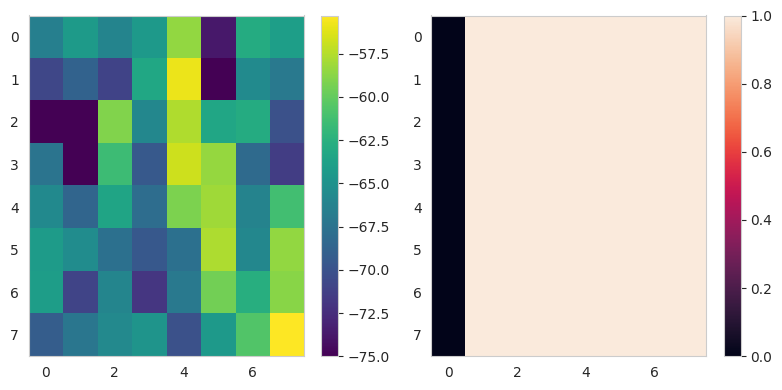

In [12]:
# Testing the results

frequencies = [18, 38, 120, 200]
row_number=0
row=loaded_patch_data_array[loaded_patch_data_array['label']=='other'][40]

print(row['label'])
ping_start = row['center_x'] - patch_size//2
ping_end = row['center_x'] + patch_size//2
ping_slice = slice(ping_start,ping_end)

range_start = row['center_y'] - patch_size//2
range_end = row['center_y'] + patch_size//2
range_slice = slice(range_start,range_end)

dat1 = survey.ds.sv.isel(ping_time=ping_slice, range=range_slice).sel(frequency=frequencies)
seabed = survey.get_seabed_mask(idx_ping=ping_start, n_pings=ping_end-ping_start,idx_range=range_start,
                                n_range=range_end-range_start,return_numpy=False)
labels = survey.get_label_slice(idx_ping=ping_start, n_pings=ping_end-ping_start,idx_range=range_start,
                                n_range=range_end-range_start,drop_na=False,return_numpy=False, categories=survey.fish_categories)
labels_values = labels.values

labels_values[labels_values==27.0] = 2.0 
labels_values[labels_values==5027.0] = 4.0 
labels_values[labels_values==6009.0] = 5.0 

# Annotation Modification
modified = refine_label_boundary(ignore_zero_inside_bbox=False).__call__(dat1.values, labels_values, [1],[1])[1]
modified[seabed==1.0] = 3.0

labels_values[seabed==1.0] = 3.0


plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(db_with_limits(dat1[3].T.values, 1, 2, frequencies)[0], cmap='viridis', aspect="auto")
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(labels_values.T, aspect="auto")
plt.colorbar()
plt.tight_layout()
plt.show()


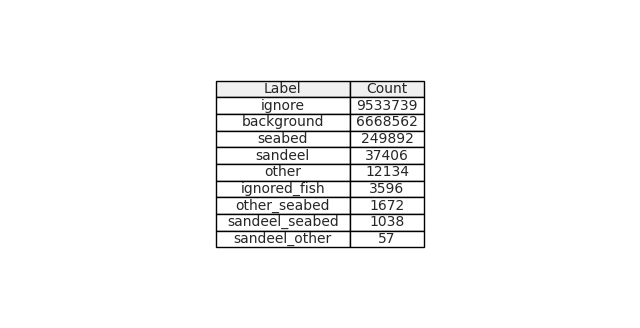

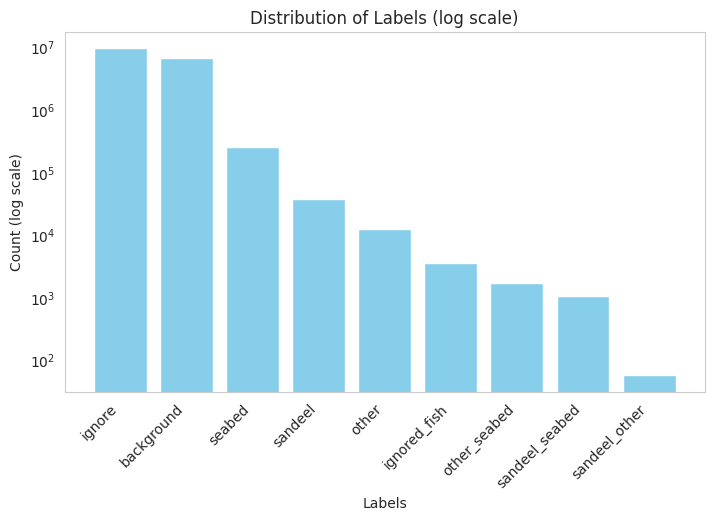

In [13]:
import matplotlib.pyplot as plt

labels, counts = np.unique(loaded_patch_data_array['label'], return_counts=True)

sorted_data = sorted(zip(labels, counts), key=lambda x: x[1], reverse=True)
labels, counts = zip(*sorted_data)

table_data = [[label, count] for label, count in zip(labels, counts)]
table_columns = ['Label', 'Count']

fig, ax_table = plt.subplots(figsize=(8, 4))
table = ax_table.table(cellText=table_data, colLabels=table_columns, cellLoc='center', loc='center', colColours=['#f0f0f0']*len(table_columns))
table.auto_set_font_size(False)
table.set_fontsize(10)

table.auto_set_column_width([0, 1])

ax_table.axis('off')

fig, ax_plot = plt.subplots(figsize=(8, 6))
bars = ax_plot.bar(labels, counts, color='skyblue')
ax_plot.set_yscale('log')
ax_plot.set_xlabel('Labels')
ax_plot.set_ylabel('Count (log scale)')
ax_plot.set_title('Distribution of Labels (log scale)')

plt.xticks(rotation=45, ha='right')

plt.subplots_adjust(left=0.1, bottom=0.3, right=0.9, top=0.9, wspace=0.3, hspace=0.3)

plt.show()


In [22]:
transposed_labels

array([[None, None, None, ..., 'background', 'background', 'background'],
       [None, None, None, ..., 'background', 'background', 'background'],
       [None, None, None, ..., 'background', 'background', 'background'],
       ...,
       [None, None, None, ..., 'ignore', 'ignore', 'ignore'],
       [None, None, None, ..., 'ignore', 'ignore', 'ignore'],
       [None, None, None, ..., 'ignore', 'ignore', 'ignore']],
      dtype=object)

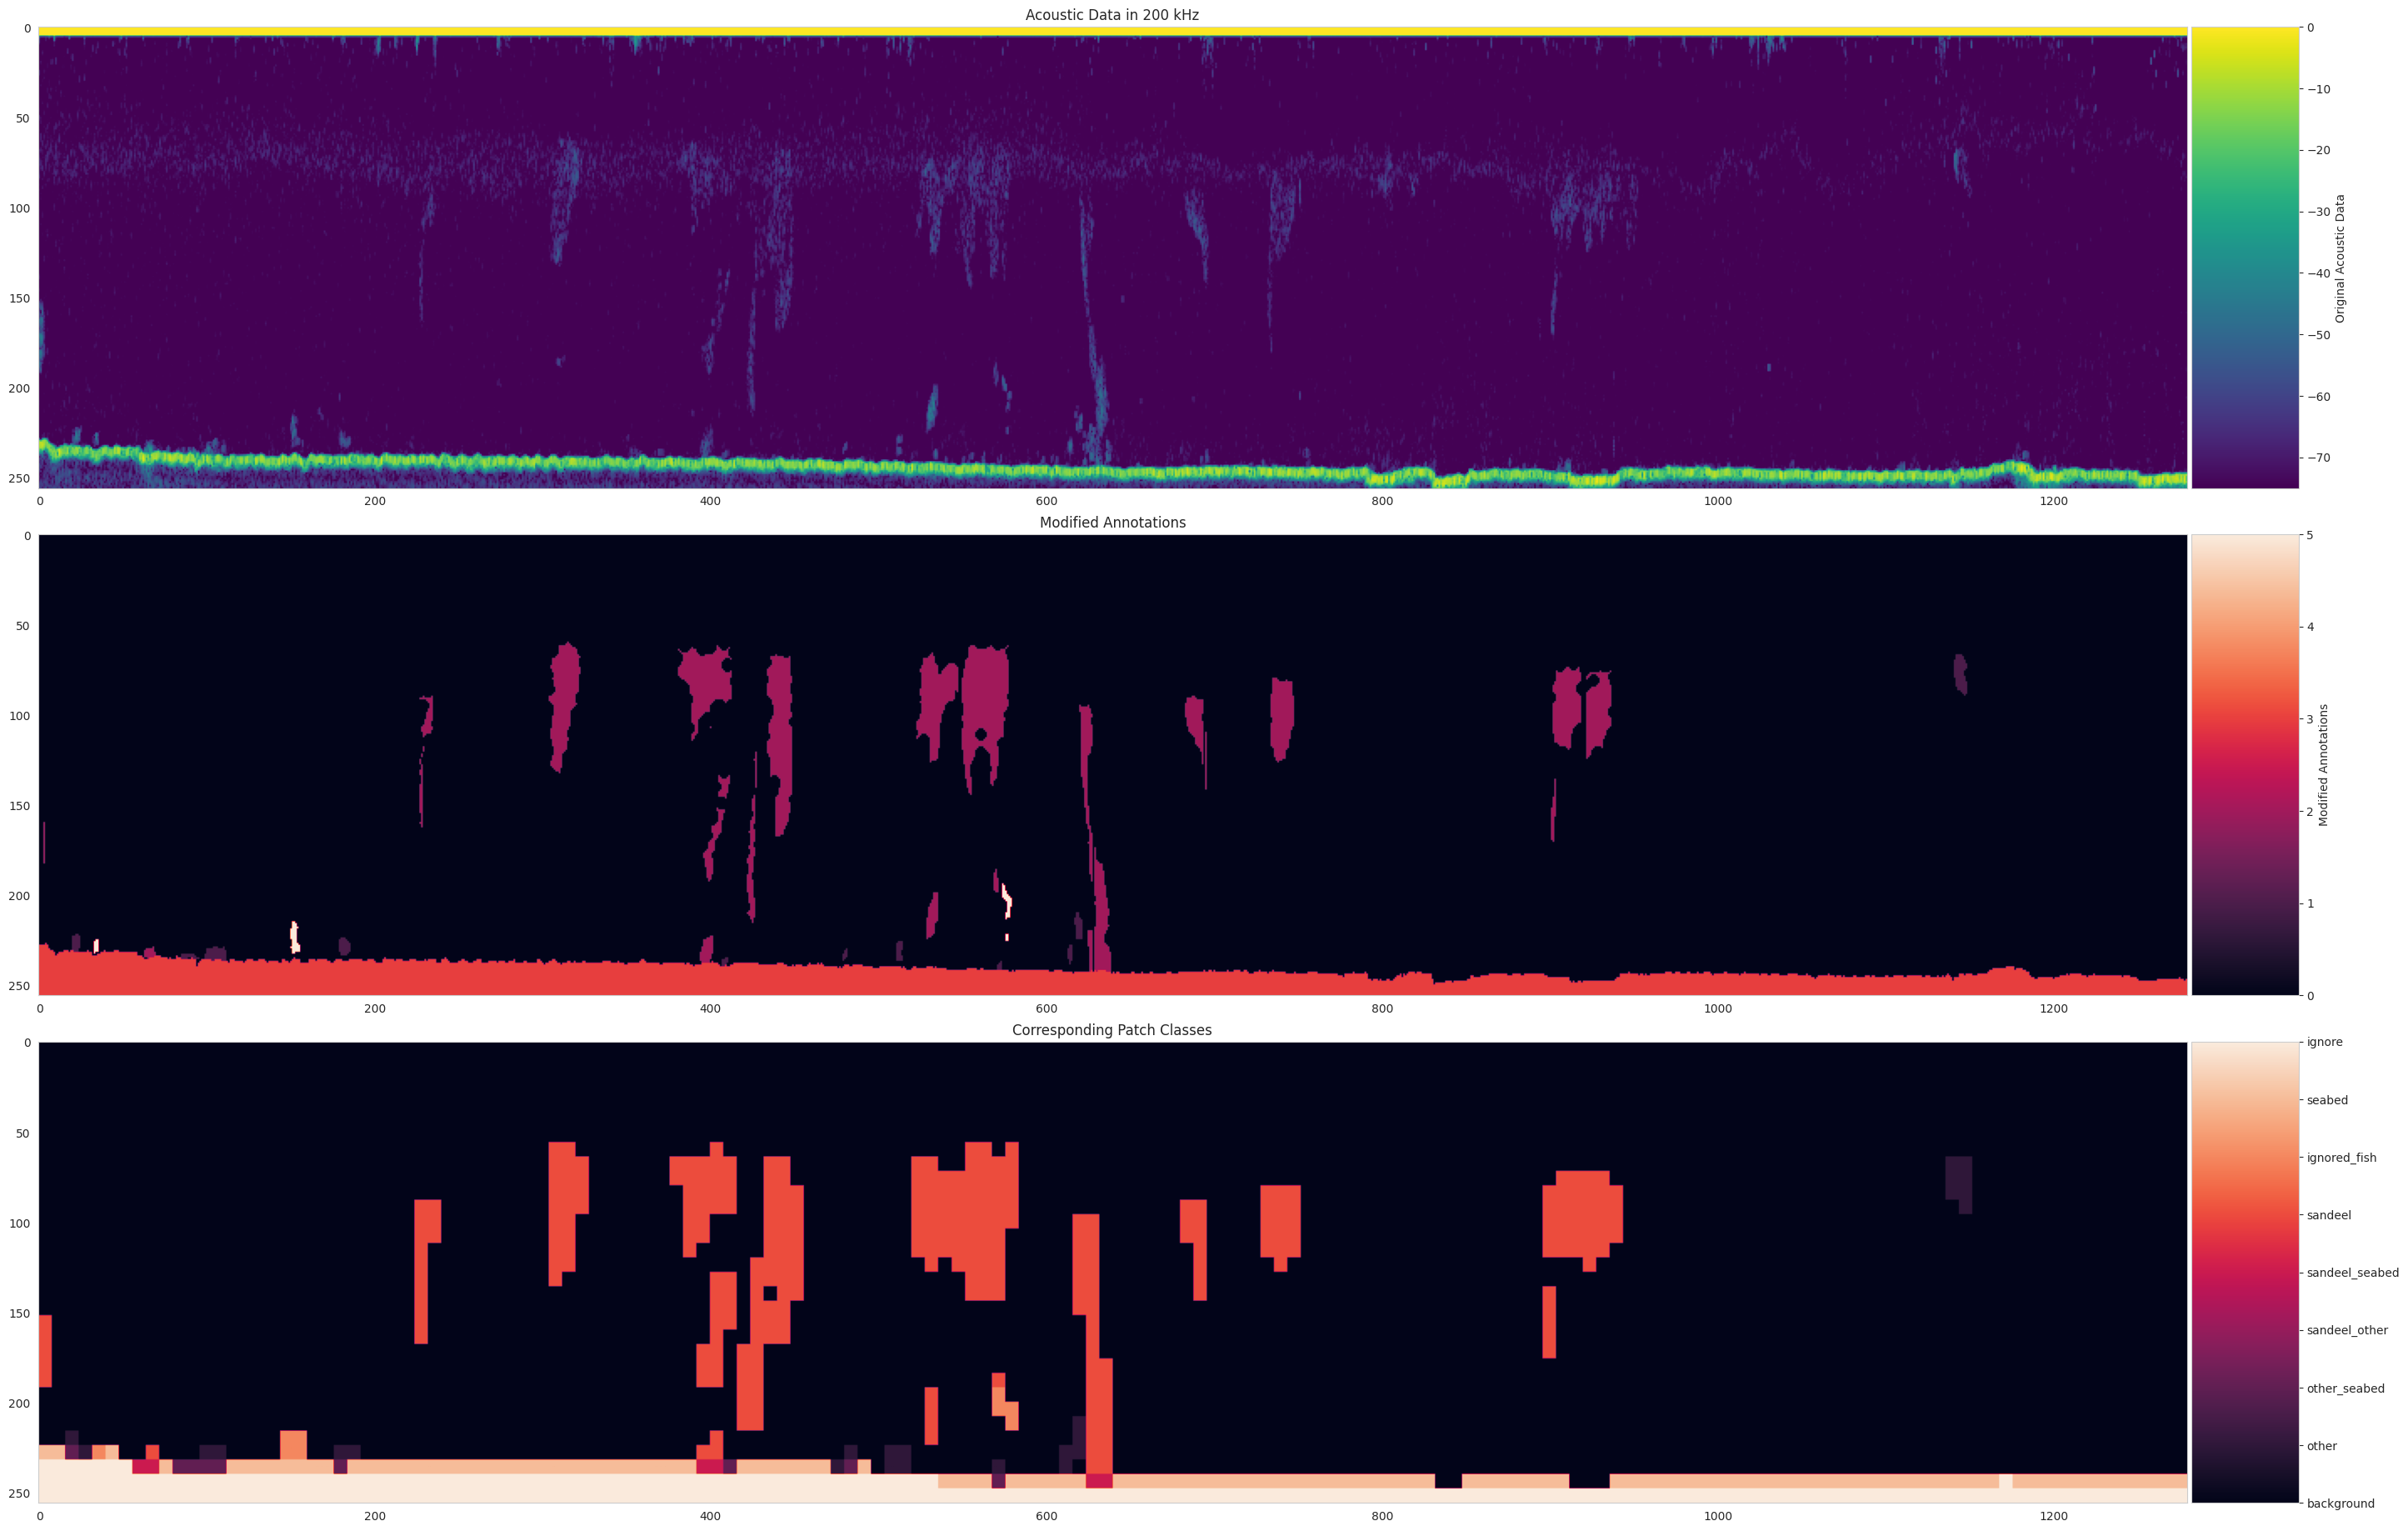

In [14]:
# Visualization

additi = 0 #-150000

ping_start = ((324195+additi)//patch_size)*patch_size
ping_end = ((325475+additi)//patch_size)*patch_size
ping_slice = slice(ping_start,ping_end)

range_start = 0
range_end = 256
range_slice = slice(range_start,range_end)

patch_size=8

# Filtering the label data
yeni_array = loaded_patch_data_array[
    (loaded_patch_data_array['center_x'] > ping_start) &
    (loaded_patch_data_array['center_x'] < ping_end) &
    (loaded_patch_data_array['center_y'] < range_end)
]

# Updating center x locations for visualization
yeni_array['center_x'] = yeni_array['center_x'] - yeni_array['center_x'].min() + patch_size//2

dat1 = survey.ds.sv.isel(ping_time=ping_slice, range=range_slice).sel(frequency=frequencies)
seabed = survey.get_seabed_mask(idx_ping=ping_start, n_pings=ping_end-ping_start,idx_range=range_start,
                                n_range=range_end-range_start,return_numpy=False)
labels = survey.get_label_slice(idx_ping=ping_start, n_pings=ping_end-ping_start,idx_range=range_start,
                                n_range=range_end-range_start,drop_na=False,return_numpy=False, categories=survey.fish_categories)
labels_values = labels.values

# Update 27 as 2 for easy colorbar
labels_values[labels_values==27.0] = 2.0
labels_values[labels_values==5027.0] = 4.0
labels_values[labels_values==6009.0] = 5.0

# Annotation Modification
modified = refine_label_boundary(ignore_zero_inside_bbox=False).__call__(dat1.values, labels_values, [1],[1])[1]
modified[seabed==1.0] = 3.0



labels_from_patch_data = np.empty_like(modified, dtype=object)

for center_x, center_y, label, _, _,  _, _, _ in yeni_array:
    start_x = max(0, center_x - patch_size // 2)
    end_x = min(modified.shape[0], center_x + patch_size // 2)
    start_y = max(0, center_y - patch_size // 2)
    end_y = min(modified.shape[1], center_y + patch_size // 2)
    
    labels_from_patch_data[start_x:end_x, start_y:end_y] = label


transposed_modified = modified.T
transposed_labels = labels_from_patch_data.T

# Map string labels to numerical values
#32x32
#label_mapping = {'background': 0, 'other': 1, 'other_seabed': 2, 'sandeel_other': 3,'sandeel_other_seabed': 4, 'sandeel_seabed': 5, 'sandeel': 6, 'ignored_fish': 7, 'seabed': 8, 'ignore': 9}
#8x8
label_mapping = {'background': 0, 'other': 1, 'other_seabed': 2, 'sandeel_other': 3, 'sandeel_seabed': 4, 'sandeel': 5, 'ignored_fish': 6, 'seabed': 7, 'ignore': 8}
numeric_labels = np.vectorize(label_mapping.get)(transposed_labels)

fig, ax = plt.subplots(3, 1, figsize=(35, 23))

im0 = ax[0].imshow(db_with_limits(dat1[3].T.values, 1, 2, frequencies)[0], cmap='viridis', aspect="auto")
ax[0].set_title('Acoustic Data in 200 kHz')
divider0 = make_axes_locatable(ax[0])
cax0 = divider0.append_axes("right", size="5%", pad=0.05)
cbar0 = plt.colorbar(im0, cax=cax0, label='Original Acoustic Data')


im1 = ax[1].imshow(transposed_modified, aspect="auto")
ax[1].set_title('Modified Annotations')
divider1 = make_axes_locatable(ax[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(im1, cax=cax1, label='Modified Annotations')

im2 = ax[2].imshow(numeric_labels, vmin=0, vmax=len(label_mapping) - 1, aspect="auto")
ax[2].set_title('Corresponding Patch Classes')
divider2 = make_axes_locatable(ax[2])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar2 = plt.colorbar(im2, cax=cax2, ticks=range(len(label_mapping)))
cbar2.set_ticklabels(list(label_mapping.keys()))

plt.subplots_adjust(hspace=0.1)

plt.show()

# Summary of the Patches

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


data = pd.DataFrame(survey.patch_data_array_all)

bin_edges = list(range(-75, 1, 15))  # Starting from -75, ending at 0, with a step size of 15

data['bin_labels'] = pd.cut(data['Sv_all_mean'], bins=bin_edges)

fig, ax1 = plt.subplots(figsize=(8, 4))
counts, bin_edges, _ = plt.hist(data['Sv_all_mean'], bins=bin_edges, edgecolor='black')

for count, edge in zip(counts, bin_edges[:-1]):
    plt.text(edge + 7.5, count, f"{int(count):,}", ha='center', va='bottom', fontsize=8)

label_table_data = []
for label in data['label'].unique():
    label_data = data[data['label'] == label]
    label_table_data.append([label, f"{len(label_data):,}", f"{label_data['Sv_all_mean'].mean():.4f}"])

label_table_data.sort(key=lambda x: int(x[1].replace(',', '')), reverse=True)

total_row = ['Total', f"{len(data):,}", f"{data['Sv_all_mean'].mean():.4f}"]
label_table_data.append(total_row)

bold_index = label_table_data.index(total_row)
for i in range(3):
    label_table_data[bold_index][i] = r"$\bf{" + str(label_table_data[bold_index][i]) + "}$"

def format_number(x, pos):
    if x >= 1e6:
        return f"{x/1e6:.1f}M"
    elif x >= 1e3:
        return f"{x/1e3:.1f}K"
    else:
        return f"{int(x)}"

label_table = plt.table(cellText=label_table_data, colLabels=['Label', 'Count', 'Mean'], loc='bottom', cellLoc='center', bbox=[0, -1.5, 1, 0.9], colColours=['#f0f0f0', '#f0f0f0', '#f0f0f0'])
label_table.auto_set_font_size(False)
label_table.set_fontsize(8)
label_table.scale(1, 4.5) 

for (i, key), cell in label_table.get_celld().items():
    if i == 0:
        cell.set_text_props(fontweight='bold')

ax1.yaxis.set_major_formatter(FuncFormatter(format_number))

plt.xlabel('Sv_all_mean Bins')
plt.ylabel('Frequency')
plt.title(f'{years[y]} - Histogram of Sv_all_mean')
plt.show()


In [11]:

from tqdm import tqdm
import numpy
import numpy as np
import matplotlib.pyplot as plt

from data.data_reader import DataReaderZarr, get_data_readers
from batch.data_transforms.db_with_limits import db_with_limits
from batch.label_transforms.refine_label_boundary import refine_label_boundary

plt.rcParams["axes.grid"] = False

years = [2007,2008,2009,2010,2011,2013,2014,2015,2016,2017,2018]
year_codes = [2007205,2008205,2009107,2010205,2011206,2013842,2014807,2015837,2016837,2017843,2018823]
y = 9

survey_path = f'/scratch/disk5/ahmet/data/{years[y]}' #'/Users/apa055/Desktop/data'

surveys = [f'/{year_codes[y]}/ACOUSTIC/GRIDDED/{year_codes[y]}_sv.zarr']
readers = [DataReaderZarr(survey_path + zarr_file) for zarr_file in surveys]

survey = readers[0]

frequencies = [18, 38, 120, 200]
patch_size = 8
threshold_percentage = 2

patch_data = []
Sv_patch_data = []

batch_size = 12800

son_hesap = patch_size * ((survey.shape[0] - patch_size) // patch_size)
for ping_start in tqdm(range(0, son_hesap, batch_size), desc="Processing batches"):
    ping_end = min(ping_start + batch_size, son_hesap)
    ping_slice = slice(ping_start, ping_end)

    range_start = 4
    range_end = 708
    range_slice = slice(range_start, range_end)

    dat1 = survey.ds.sv.isel(ping_time=ping_slice, range=range_slice).sel(frequency=frequencies)
    dat1_200 = db_with_limits(dat1[3].values, 1, 2, frequencies)[0]
    dat1_all = db_with_limits(dat1.values, 1, 2, frequencies)[0]

    seabed = survey.get_seabed_mask(idx_ping=ping_start, n_pings=ping_end - ping_start, idx_range=range_start,
                                    n_range=range_end - range_start, return_numpy=False)
    labels = survey.get_label_slice(idx_ping=ping_start, n_pings=ping_end - ping_start, idx_range=range_start,
                                    n_range=range_end - range_start, drop_na=False, return_numpy=False,
                                    categories=survey.fish_categories)
    labels_values = labels.values

    labels_values[labels_values == 27.0] = 2.0 
    labels_values[labels_values == 5027.0] = 4.0
    labels_values[labels_values == 6009.0] = 5.0

    # Annotation Modification
    modified = refine_label_boundary(ignore_zero_inside_bbox=False).__call__(dat1.values, labels_values, [1], [1])[1]
    modified[seabed == 1.0] = 3.0

    for i in range(0, modified.shape[0], patch_size):
        for j in range(0, modified.shape[1], patch_size):
            # Sv_200_mean = dat1_200[i:i+patch_size, j:j+patch_size].mean()
            Sv_all_mean = dat1_all[:, i:i + patch_size, j:j + patch_size].mean()
            patch = modified[i:i + patch_size, j:j + patch_size]

            sv_patch = dat1_all[:,i:i + patch_size, j:j + patch_size]

            count_0 = np.sum(patch == 0)
            count_1 = np.sum(patch == 1)
            count_2 = np.sum(patch == 2)
            count_3 = np.sum(patch == 3)

            count_4 = np.sum(patch == 4)
            count_5 = np.sum(patch == 5)

            total_elements = patch.size

            percentage_0 = count_0 / total_elements * 100
            percentage_1 = count_1 / total_elements * 100
            percentage_2 = count_2 / total_elements * 100
            percentage_3 = count_3 / total_elements * 100

            if percentage_2 > threshold_percentage:
                patch_label = 'sandeel'
            if percentage_1 > threshold_percentage:
                patch_label = 'other'
            if percentage_1 <= threshold_percentage and percentage_2 <= threshold_percentage:
                patch_label = 'background'
            if percentage_1 > threshold_percentage and percentage_2 > threshold_percentage:
                patch_label = 'sandeel_other'
            if count_3 >= 50:
                patch_label = 'ignore'

            if count_4 > 4 or count_5 > 4:
                patch_label = 'ignored_fish'
            if 'sandeel' in patch_label and count_3 > 2:
                patch_label = 'sandeel_seabed'
            elif 'other' in patch_label and count_3 > 2:
                patch_label = 'other_seabed'
            elif 'background' in patch_label and 0 < count_3 < total_elements - 8:
                patch_label = 'seabed'
            elif 'sandeel_other' in patch_label and count_3 > 0:
                patch_label = 'sandeel_other_seabed'

            center_x = i + patch_size // 2 + ping_start
            center_y = j + patch_size // 2
            if not np.isnan(sv_patch).any() and patch_label != 'ignore':
                patch_data.append((center_x, center_y, patch_label, count_1, count_2, count_3, Sv_all_mean, total_elements))
                Sv_patch_data.append(sv_patch)
            else:
                pass

dtype = [('center_x', int), ('center_y', int), ('label', 'U20'), ('count_1', int), ('count_2', int), ('count_3', int),
         ('Sv_all_mean', float), ('total_elements', int)]

patch_data_array_all = np.array(patch_data, dtype=dtype)

np.save(
    f'/scratch/disk5/ahmet/data/{years[y]}/{year_codes[y]}/ACOUSTIC/GRIDDED/{year_codes[y]}_patch_data_array_all_{patch_size}w.npy',
    patch_data_array_all)


Processing batches:   1%|          | 1/118 [00:16<32:15, 16.54s/it]


KeyboardInterrupt: 

In [15]:
np.array(Sv_patch_data).shape

(72799, 4, 8, 8)

In [13]:
j

696

In [14]:
dat1_all[:,i:i + patch_size, j:j + patch_size].shape

(4, 8, 8)